# Initialization

In [1]:
# data processing
import numpy as np
import pandas as pd 
from collections import defaultdict

# data visualization
import seaborn as sns
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import style
sns.set()
import urllib.request
import keras_tuner as kt


import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))
from tensorflow import keras
from datetime import datetime

# Notebook auto reloads code. (Ref: http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython)
%load_ext autoreload
%autoreload 2

C:\intelpython3\envs\napari-env\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\intelpython3\envs\napari-env\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
C:\intelpython3\envs\napari-env\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [2]:
%load_ext tensorboard


In [2]:
# If using Google Colab
from google.colab import drive
BASE_PATH = '/content/drive'
drive.mount(BASE_PATH)

# change directory
import os
PROJECT_PATH = os.path.join(BASE_PATH, "MyDrive", "ECBM4040", "FinalProject", "recreating-residual-attention-network")
os.chdir(PROJECT_PATH)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
#adjust filepath so that working directory is folder "recreating-residual-attention-network"
%pwd
%cd .. 

C:\Users\JacobNye\Documents\GitHub\recreating-residual-attention-network


In [56]:
%cd "GitHub\\recreating-residual-attention-network"

C:\Users\JacobNye\Documents\GitHub\recreating-residual-attention-network


In [3]:
%pwd

'C:\\Users\\JacobNye\\Documents\\GitHub\\recreating-residual-attention-network\\nbks'

In [5]:
# Import created modules
from src.models.ResidualAttentionNetwork import ResidualAttentionNetwork, Attention56, Attention92, Attention128, Attention164
from src.utils import generate_data

# Modelling

In [6]:
INPUT_SHAPE, NUM_CLASS, train_ds, val_ds, test_ds, _ = generate_data.get_cifar10()

In [7]:
BATCH_SIZE = 256
N_EPOCH = 100


In [8]:
train_ds = train_ds.shuffle(buffer_size=BATCH_SIZE*4).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.shuffle(buffer_size=BATCH_SIZE*4).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.shuffle(buffer_size=BATCH_SIZE*4).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

In [35]:
# !nvidia-smi

## Naive Attention Learning vs Residual Attention Learning

### Naive Attention Learning

In [36]:
tf.version.VERSION


'2.5.0'

In [37]:
ran_model = ResidualAttentionNetwork(input_shape=INPUT_SHAPE, num_class=NUM_CLASS, learning_type='nal')
inputs = tf.keras.Input((32, 32, 3))
ran_model(inputs)
ran_model.summary()

Model: "residual_attention_network_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_278 (Conv2D)          multiple                  864       
_________________________________________________________________
batch_normalization_214 (Bat multiple                  128       
_________________________________________________________________
re_lu_214 (ReLU)             multiple                  0         
_________________________________________________________________
max_pooling2d_14 (MaxPooling multiple                  0         
_________________________________________________________________
residual_unit_66 (ResidualUn multiple                  6432      
_________________________________________________________________
attention_module_6 (Attentio multiple 

In [39]:
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))


Number of devices: 2


In [47]:
logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
file_writer = tf.summary.create_file_writer(logdir + "/metrics")
file_writer.set_as_default()

def lr_schedule(epoch):
    learning_rate = 0.005
    if epoch > 64:
        learning_rate = 0.00001
    if epoch > 90:
        learning_rate = 0.0000001
    tf.summary.scalar('learning rate', data=learning_rate, step=epoch)
    return learning_rate

tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)
lr_callback = keras.callbacks.LearningRateScheduler(lr_schedule)

# strategy = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

# Open a strategy scope.
# with strategy.scope():
  # Everything that creates variables should be under the strategy scope.
  # In general this is only model construction & `compile()`.
  
ran_model = ResidualAttentionNetwork(input_shape=INPUT_SHAPE, num_class=NUM_CLASS, learning_type='nal')

nal_model = ran_model

nal_model.compile(optimizer=tf.keras.optimizers.Adam(), 
              loss=tf.keras.losses.CategoricalCrossentropy(), 
              metrics=['accuracy'])


history_NAL = nal_model.fit(train_ds,
                        validation_data=val_ds,
                        epochs=N_EPOCH, callbacks=[lr_callback,tensorboard_callback], verbose=1)



Number of devices: 2
Epoch 1/100
157/157 [==============================] - 34s 155ms/step - loss: 2.2293 - accuracy: 0.1882 - val_loss: 2.9642 - val_accuracy: 0.1220
Epoch 2/100
157/157 [==============================] - 21s 134ms/step - loss: 1.9513 - accuracy: 0.2762 - val_loss: 2.6623 - val_accuracy: 0.1547
Epoch 3/100
157/157 [==============================] - 21s 135ms/step - loss: 1.8756 - accuracy: 0.3063 - val_loss: 2.0693 - val_accuracy: 0.2481
Epoch 4/100
157/157 [==============================] - 21s 133ms/step - loss: 1.8310 - accuracy: 0.3263 - val_loss: 1.8631 - val_accuracy: 0.3124
Epoch 5/100
157/157 [==============================] - 21s 134ms/step - loss: 1.7896 - accuracy: 0.3462 - val_loss: 1.8735 - val_accuracy: 0.3546
Epoch 6/100
157/157 [==============================] - 21s 133ms/step - loss: 1.7523 - accuracy: 0.3591 - val_loss: 1.8747 - val_accuracy: 0.3458
Epoch 7/100
157/157 [==============================] - 21s 134ms/step - loss: 1.7273 - accuracy: 0.3666

In [49]:
%pwd

'C:\\Users\\JacobNye\\Documents'

In [191]:
# %tensorboard --logdir logs/scalars


### NAL - with ImageDatagen Preprocessing

In [66]:
x_train, y_train, x_test, y_test, datagen = generate_data2.get_cifar10_old(rotation_range=20,
                                                                      width_shift_range=0.2,
                                                                      height_shift_range=0.2,
                                                                      horizontal_flip=True,
                                                                      validation_split=0.2)

In [67]:
INPUT_SHAPE = x_train.shape[1:]
NUM_CLASS = y_train.shape[1]
BATCH_SIZE = 256
N_EPOCH = 100

In [68]:
ran_model = ResidualAttentionNetwork(input_shape=INPUT_SHAPE, num_class=NUM_CLASS, learning_type='nal')
inputs = tf.keras.Input((32, 32, 3))
ran_model(inputs)
ran_model.summary()

Model: "residual_attention_network_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_1529 (Conv2D)         multiple                  864       
_________________________________________________________________
batch_normalization_1177 (Ba multiple                  128       
_________________________________________________________________
re_lu_1177 (ReLU)            multiple                  0         
_________________________________________________________________
max_pooling2d_77 (MaxPooling multiple                  0         
_________________________________________________________________
residual_unit_363 (ResidualU multiple                  6432      
_________________________________________________________________
attention_module_33 (Attenti multiple

In [69]:
logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")+'_Nal_Datagen'
file_writer = tf.summary.create_file_writer(logdir + "/metrics")
file_writer.set_as_default()

def lr_schedule(epoch):
    learning_rate = 0.005
    if epoch > 64:
        learning_rate = 0.00001
    if epoch > 90:
        learning_rate = 0.0000001
    tf.summary.scalar('learning rate', data=learning_rate, step=epoch)
    return learning_rate

tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)
lr_callback = keras.callbacks.LearningRateScheduler(lr_schedule)

model_nal_datagen = ran_model

model_nal_datagen.compile(optimizer=tf.keras.optimizers.Adam(), 
              loss=tf.keras.losses.CategoricalCrossentropy(), 
              metrics=['accuracy'])


history_nal_datagen = model_nal_datagen.fit(datagen.flow(x_train, y_train, batch_size=BATCH_SIZE, subset='training'), 
                    validation_data=datagen.flow(x_train, y_train, batch_size=BATCH_SIZE, subset='validation'),
                    epochs=N_EPOCH,callbacks=[lr_callback,tensorboard_callback], verbose=1)

Epoch 1/100
157/157 [==============================] - 37s 172ms/step - loss: 2.3868 - accuracy: 0.1317 - val_loss: 2.3204 - val_accuracy: 0.1073
Epoch 2/100
157/157 [==============================] - 24s 153ms/step - loss: 2.1140 - accuracy: 0.1948 - val_loss: 2.1761 - val_accuracy: 0.1858
Epoch 3/100
157/157 [==============================] - 24s 153ms/step - loss: 2.0141 - accuracy: 0.2362 - val_loss: 3.4918 - val_accuracy: 0.1821
Epoch 4/100
157/157 [==============================] - 24s 151ms/step - loss: 1.9526 - accuracy: 0.2641 - val_loss: 2.8382 - val_accuracy: 0.2115
Epoch 5/100
157/157 [==============================] - 24s 151ms/step - loss: 1.9785 - accuracy: 0.2552 - val_loss: 1.9178 - val_accuracy: 0.2791
Epoch 6/100
157/157 [==============================] - 24s 150ms/step - loss: 1.8929 - accuracy: 0.2860 - val_loss: 2.6464 - val_accuracy: 0.1731
Epoch 7/100
157/157 [==============================] - 24s 150ms/step - loss: 1.8673 - accuracy: 0.2964 - val_loss: 2.0193 -

KeyboardInterrupt: 

### Residual Attention Learning

In [71]:
ran_model = ResidualAttentionNetwork(input_shape=INPUT_SHAPE, num_class=NUM_CLASS, learning_type='arl')
inputs = tf.keras.Input((32, 32, 3))
ran_model(inputs)
ran_model.summary()

Model: "residual_attention_network_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, None, None, None)  0         
_________________________________________________________________
conv2d_1668 (Conv2D)         multiple                  864       
_________________________________________________________________
batch_normalization_1284 (Ba multiple                  128       
_________________________________________________________________
re_lu_1284 (ReLU)            multiple                  0         
_________________________________________________________________
max_pooling2d_84 (MaxPooling multiple                  0         
_________________________________________________________________
residual_unit_396 (ResidualU multiple                  6432      
_________________________________________________________________
attention_module_36 (Attenti multiple

In [72]:
logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S") + "_ARL"
file_writer = tf.summary.create_file_writer(logdir + "/metrics")
file_writer.set_as_default()

def lr_schedule(epoch):
    learning_rate = 0.005
    if epoch > 64:
        learning_rate = 0.00001
    if epoch > 90:
        learning_rate = 0.0000001
    tf.summary.scalar('learning rate', data=learning_rate, step=epoch)
    return learning_rate

tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)
lr_callback = keras.callbacks.LearningRateScheduler(lr_schedule)

arl_model = ran_model

arl_model.compile(optimizer=tf.keras.optimizers.Adam(), 
                  loss=tf.keras.losses.CategoricalCrossentropy(), 
                  metrics=['accuracy'])


history_arl = arl_model.fit(train_ds,
                        validation_data=val_ds,
                        epochs=N_EPOCH,callbacks=[lr_callback,tensorboard_callback], verbose=1)

Epoch 1/100
157/157 [==============================] - 34s 158ms/step - loss: 2.3013 - accuracy: 0.1608 - val_loss: 2.5491 - val_accuracy: 0.1000
Epoch 2/100
157/157 [==============================] - 22s 137ms/step - loss: 2.0182 - accuracy: 0.2323 - val_loss: 4.3530 - val_accuracy: 0.1741
Epoch 3/100
157/157 [==============================] - 21s 134ms/step - loss: 1.9101 - accuracy: 0.2662 - val_loss: 1.9617 - val_accuracy: 0.2278
Epoch 4/100
157/157 [==============================] - 21s 135ms/step - loss: 1.8617 - accuracy: 0.2923 - val_loss: 2.0192 - val_accuracy: 0.2946
Epoch 5/100
157/157 [==============================] - 21s 133ms/step - loss: 1.8280 - accuracy: 0.3099 - val_loss: 1.8561 - val_accuracy: 0.3330
Epoch 6/100
157/157 [==============================] - 21s 133ms/step - loss: 1.7947 - accuracy: 0.3271 - val_loss: 2.4942 - val_accuracy: 0.2282
Epoch 7/100
157/157 [==============================] - 21s 134ms/step - loss: 1.7893 - accuracy: 0.3320 - val_loss: 2.1266 -

Epoch 57/100
157/157 [==============================] - 21s 133ms/step - loss: 1.0631 - accuracy: 0.6366 - val_loss: 1.0826 - val_accuracy: 0.6355
Epoch 58/100
157/157 [==============================] - 21s 133ms/step - loss: 1.0586 - accuracy: 0.6388 - val_loss: 1.4425 - val_accuracy: 0.5610
Epoch 59/100
157/157 [==============================] - 21s 133ms/step - loss: 1.0607 - accuracy: 0.6376 - val_loss: 1.2182 - val_accuracy: 0.6018
Epoch 60/100
157/157 [==============================] - 21s 133ms/step - loss: 1.0447 - accuracy: 0.6470 - val_loss: 1.0946 - val_accuracy: 0.6460
Epoch 61/100
157/157 [==============================] - 21s 133ms/step - loss: 1.1092 - accuracy: 0.6214 - val_loss: 1.5631 - val_accuracy: 0.5640
Epoch 62/100
157/157 [==============================] - 21s 133ms/step - loss: 1.0398 - accuracy: 0.6478 - val_loss: 1.2466 - val_accuracy: 0.5915
Epoch 63/100
157/157 [==============================] - 21s 134ms/step - loss: 1.0512 - accuracy: 0.6437 - val_loss: 1

In [74]:
%tensorboard --logdir logs/scalars/20211207-120952_ARL


In [73]:
#Save Models for posterity
arl_model.save_weights('cifar10_ARL_ADAM_RAN_100epoch_val.h5')
# NAL model
nal_model.save_weights('cifar10_NAL_ADAM_RAN_100epoch_val.h5')

## Different number of attention module

In this part, the experiment is done using Residual Attention Learning mechanism

### Attention-56

In [75]:
ran_model = Attention56()
inputs = tf.keras.Input((32, 32, 3))
ran_model(inputs)
ran_model.summary()

Model: "attention56"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_1807 (Conv2D)         multiple                  864       
_________________________________________________________________
batch_normalization_1391 (Ba multiple                  128       
_________________________________________________________________
re_lu_1391 (ReLU)            multiple                  0         
_________________________________________________________________
max_pooling2d_91 (MaxPooling multiple                  0         
_________________________________________________________________
residual_unit_429 (ResidualU multiple                  19520     
_________________________________________________________________
attention_module_39 (Attenti multiple                  

In [76]:
logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S") + "_A56"
file_writer = tf.summary.create_file_writer(logdir + "/metrics")
file_writer.set_as_default()

def lr_schedule(epoch):
    learning_rate = 0.005
    if epoch > 64:
        learning_rate = 0.00001
    if epoch > 90:
        learning_rate = 0.0000001
    tf.summary.scalar('learning rate', data=learning_rate, step=epoch)
    return learning_rate

tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)
lr_callback = keras.callbacks.LearningRateScheduler(lr_schedule)

a56_model = ran_model

a56_model.compile(optimizer=tf.keras.optimizers.Adam(), 
                  loss=tf.keras.losses.CategoricalCrossentropy(), 
                  metrics=['accuracy'])


history_a56 = a56_model.fit(train_ds,
                        validation_data=val_ds,
                        epochs=N_EPOCH,callbacks=[lr_callback,tensorboard_callback], verbose=1)

Epoch 1/100
157/157 [==============================] - 45s 218ms/step - loss: 2.3141 - accuracy: 0.1665 - val_loss: 2.3397 - val_accuracy: 0.1383
Epoch 2/100
157/157 [==============================] - 30s 194ms/step - loss: 2.0320 - accuracy: 0.2306 - val_loss: 2.3859 - val_accuracy: 0.1397
Epoch 3/100
157/157 [==============================] - 30s 192ms/step - loss: 1.9489 - accuracy: 0.2453 - val_loss: 4.5526 - val_accuracy: 0.1431
Epoch 4/100
157/157 [==============================] - 30s 192ms/step - loss: 1.9082 - accuracy: 0.2576 - val_loss: 1.8917 - val_accuracy: 0.2810
Epoch 5/100
157/157 [==============================] - 30s 192ms/step - loss: 1.8593 - accuracy: 0.2888 - val_loss: 1.8990 - val_accuracy: 0.2956
Epoch 6/100
157/157 [==============================] - 30s 192ms/step - loss: 1.8363 - accuracy: 0.2940 - val_loss: 1.9351 - val_accuracy: 0.2481
Epoch 7/100
157/157 [==============================] - 30s 192ms/step - loss: 1.8125 - accuracy: 0.3020 - val_loss: 2.2190 -

## Hyper Parameter tuning - learning rate for A56 Model

In [86]:
def model_builder(hp):
    ran_model = ResidualAttentionNetwork()
    inputs = tf.keras.Input((32, 32, 3))
    ran_model(inputs)
    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-1, 1e-2,5e-2,1e-3,5e-3,1e-4])
    ran_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate), 
              loss=tf.keras.losses.CategoricalCrossentropy(), 
              metrics=['accuracy'])
    return ran_model

In [89]:
tuner_a56 = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=30,
                     factor=3,
                     directory='NERD_dir',
                     project_name='NERD_Final_Project_A56_LR2',
                     hyperband_iterations=10)

In [90]:
logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S") + "_A56_Hyperparams2"
file_writer = tf.summary.create_file_writer(logdir + "/metrics")
file_writer.set_as_default()

# stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)


# tuner.search(x_train, y_train, epochs=50, validation_data=(x_test, y_test), callbacks=[stop_early])
tuner_a56.search(train_ds, epochs=30, validation_data=val_ds, callbacks=[tensorboard_callback])


Trial 6 Complete [00h 00m 58s]
val_accuracy: 0.10000000149011612

Best val_accuracy So Far: 0.20080000162124634
Total elapsed time: 00h 05m 57s
INFO:tensorflow:Oracle triggered exit


In [91]:

# Get the optimal hyperparameters
best_hps=tuner_a56.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")


The hyperparameter search is complete. The optimal learning rate for the optimizer
is 0.001.



In [ ]:
best_model = tuner_a56.get_best_models()[0]


In [92]:
tuner_a56.results_summary(num_trials=10)


Results summary
Results in NERD_dir\NERD_Final_Project_A56_LR2
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
learning_rate: 0.001
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 3
tuner/round: 0
Score: 0.20080000162124634
Trial summary
Hyperparameters:
learning_rate: 0.01
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 3
tuner/round: 0
Score: 0.1931000053882599
Trial summary
Hyperparameters:
learning_rate: 0.05
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 3
tuner/round: 0
Score: 0.15729999542236328
Trial summary
Hyperparameters:
learning_rate: 0.005
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 3
tuner/round: 0
Score: 0.1509000062942505
Trial summary
Hyperparameters:
learning_rate: 0.0001
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 3
tuner/round: 0
Score: 0.10419999808073044
Trial summary
Hyperparameters:
learning_rate: 0.1
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 3
tuner/round: 

In [ ]:
%tensorboard --logdir logdir


In [97]:
def model_builder(hp):
    ran_model = ResidualAttentionNetwork()
    inputs = tf.keras.Input((32, 32, 3))
    ran_model(inputs)
    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.01, 0.001, or 0.0001
#     hp_learning_rate =  hp.Float('learning_rate', 1e-4, 1e-1, sampling='log'),
    ran_model.compile(optimizer=tf.keras.optimizers.Adam(hp.Float('learning_rate', 1e-4, 1e-1, sampling='log')), 
              loss=tf.keras.losses.CategoricalCrossentropy(), 
              metrics=['accuracy'])
    return ran_model

In [98]:
tuner_a56_logSample = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=30,
                     factor=3,
                     directory='NERD_dir',
                     project_name='NERD_Final_Project_A56_LR3LogSample',
                     hyperband_iterations=2)

INFO:tensorflow:Reloading Oracle from existing project NERD_dir\NERD_Final_Project_A56_LR3LogSample\oracle.json


In [99]:
logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S") + "_A56_Hyperparams3_logSample"
file_writer = tf.summary.create_file_writer(logdir + "/metrics")
file_writer.set_as_default()

# stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)


# tuner.search(x_train, y_train, epochs=50, validation_data=(x_test, y_test), callbacks=[stop_early])
tuner_a56_logSample.search(train_ds, validation_data=val_ds, callbacks=[tensorboard_callback])


Trial 632 Complete [00h 00m 59s]
val_accuracy: 0.14030000567436218

Best val_accuracy So Far: 0.554099977016449
Total elapsed time: 03h 26m 22s

Search: Running Trial #633

Hyperparameter    |Value             |Best Value So Far 
learning_rate     |0.017579          |0.0037356         
tuner/epochs      |2                 |30                
tuner/initial_e...|0                 |0                 
tuner/bracket     |3                 |0                 
tuner/round       |0                 |0                 

Epoch 1/2
 21/157 [===>..........................] - ETA: 26s - loss: 2.9189 - accuracy: 0.1064

KeyboardInterrupt: 

In [103]:

# Get the optimal hyperparameters
best_hps=tuner_a56_logSample.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")


The hyperparameter search is complete. The optimal learning rate for the optimizer
is 0.0037356213647702042.



In [105]:
best_model_a56_logSample = tuner_a56_logSample.get_best_models()[0]


In [117]:
#save best model from hyper-parameter tuning (even though it's not converged yet, can complete
# training later)
best_model_a56_logSample.save('tuned_hyperParam_a56model_LR_003735621_valAcc_55-409',save_format="tf",save_traces=True)

C:\intelpython3\envs\napari-env\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: tuned_hyperParam_a56model_LR_003735621_valAcc_55-409\assets


INFO:tensorflow:Assets written to: tuned_hyperParam_a56model_LR_003735621_valAcc_55-409\assets


In [109]:
#try saving weights
best_model_a56_logSample.save_weights("tuned_hyperParam_a56model_LR_003735621.h5")

In [ ]:
#reload model using weights

### Reload model and test that it saved correctly

In [107]:
check_Saved_model_input = train_ds.take(1)
print(f'The shape of the training example is {check_Saved_model_input}')
print(check_Saved_model_input)

The shape of the training example is <TakeDataset shapes: ((None, 32, 32, 3), (None, 10)), types: (tf.float32, tf.float32)>
<TakeDataset shapes: ((None, 32, 32, 3), (None, 10)), types: (tf.float32, tf.float32)>


In [111]:
print(best_model_a56_logSample.predict(check_Saved_model_input))

[[1.9159985e-05 2.3684504e-05 1.1471750e-03 ... 5.4037064e-05
  7.6295146e-05 8.9233894e-05]
 [4.9112178e-02 3.5933363e-01 8.0842055e-02 ... 4.4143900e-02
  1.3324639e-01 1.0280525e-01]
 [1.3399981e-02 3.3346142e-03 1.3886322e-01 ... 6.9460170e-03
  1.1492625e-02 7.8444351e-03]
 ...
 [4.6996167e-03 3.2819377e-03 6.1856151e-02 ... 1.0036735e-02
  6.4579812e-03 6.8924753e-03]
 [2.3066236e-01 3.1719648e-04 6.8553436e-01 ... 2.0044869e-02
  1.0509324e-03 6.0144713e-04]
 [8.6892731e-03 3.1257526e-03 2.7720828e-03 ... 1.7324180e-04
  9.7709924e-01 5.9128151e-04]]


In [112]:
reconstructed_model.predict(check_Saved_model_input)

array([[3.0352795e-04, 6.2452888e-01, 2.6148855e-04, ..., 2.6801194e-04,
        3.7148970e-03, 3.6928642e-01],
       [2.8067182e-03, 2.5755155e-01, 1.1194212e-03, ..., 2.1718931e-03,
        3.3691376e-02, 6.9409901e-01],
       [6.3315493e-01, 2.2711228e-03, 2.0162743e-02, ..., 6.1070332e-03,
        2.8203464e-01, 2.6529711e-02],
       ...,
       [1.0766190e-02, 5.4333820e-03, 1.4444451e-01, ..., 2.3691896e-02,
        7.9813125e-03, 7.6871123e-03],
       [4.4921835e-04, 4.8116205e-04, 8.4037032e-07, ..., 8.5891861e-07,
        9.9855775e-01, 5.0545618e-04],
       [3.6338621e-03, 3.6874476e-01, 2.3077053e-03, ..., 1.6497914e-03,
        5.5777091e-01, 4.6676204e-02]], dtype=float32)

In [116]:
# Check that the saved model can be loaded and that it's prediction matches the model we had saved
# It can be used to reconstruct the model identically.
reconstructed_model = keras.models.load_model("tuned_hyperParam_a56model_LR_003735621_valAcc_55-409")

# Let's check:
np.testing.assert_allclose(
    best_model_a56_logSample.predict(check_Saved_model_input), reconstructed_model.predict(check_Saved_model_input)
)



#Uncomment below if we want to continue training the reconstructed model
# The reconstructed model is already compiled and has retained the optimizer
# state, so training can resume:
# reconstructed_model.fit(test_input, test_target)

AssertionError: 
Not equal to tolerance rtol=1e-07, atol=0

Mismatched elements: 2560 / 2560 (100%)
Max absolute difference: 0.9986248
Max relative difference: 20028352.
 x: array([[9.578081e-03, 4.628582e-01, 1.020242e-03, ..., 6.517326e-04,
        5.817404e-02, 4.655172e-01],
       [2.518133e-04, 2.548963e-04, 8.607103e-03, ..., 3.598077e-03,...
 y: array([[2.053788e-02, 2.993037e-03, 1.313013e-01, ..., 4.321250e-02,
        9.731065e-03, 2.982432e-03],
       [2.702215e-03, 4.482748e-05, 1.023285e-02, ..., 9.157217e-01,...

In [ ]:
assert np.allclose(model.predict(x), loaded_model.predict(x))


In [118]:
tuner_a56_logSample.results_summary(num_trials=10)


Results summary
Results in NERD_dir\NERD_Final_Project_A56_LR3LogSample
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
learning_rate: 0.0037356213647702042
tuner/epochs: 30
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.554099977016449
Trial summary
Hyperparameters:
learning_rate: 0.0021680453606817062
tuner/epochs: 30
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.5479000210762024
Trial summary
Hyperparameters:
learning_rate: 0.0016276004627192287
tuner/epochs: 30
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.54339998960495
Trial summary
Hyperparameters:
learning_rate: 0.0015598166106587962
tuner/epochs: 30
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.5414000153541565
Trial summary
Hyperparameters:
learning_rate: 0.0015173732021127955
tuner/epochs: 30
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.5382000207901001
Trial summary
Hyperparameters:

In [157]:
# logdir = 'C:\\Users\\JacobNye\\Documents\\GitHub\\recreating-residual-attention-network\\logs\\scalars\\20211207-185519_A56_Hyperparams3_logSample'

In [158]:
# logdir

'C:\\Users\\JacobNye\\Documents\\GitHub\\recreating-residual-attention-network\\logs\\scalars\\20211207-185519_A56_Hyperparams3_logSample'

In [134]:
# logdir='logs/scalars/20211207-185519_A56_Hyperparams3_logSample'

# logdir='logs//scalars//20211207-185519_A56_Hyperparams3_logSample//ab91f98c7a491a9878fb54a621319e00//execution0//'

In [162]:
# !taskkill /F /PID 23724

SUCCESS: The process with PID 23724 has been terminated.


In [146]:
# !kill 12124

'kill' is not recognized as an internal or external command,
operable program or batch file.


In [165]:
# mylogdir = "C:\\Users\\JacobNye\\Documents\\GitHub\\recreating-residual-attention-network\\logs2\\scalars\\20211207-185519_A56_Hyper"

In [168]:
# %tensorboard --logdir {mylogdir}  --host localhost


## Retrain A56 Model but with Optimal Learning rate from hyper-parameter tuning

In [167]:
%pwd

'C:\\Users\\JacobNye\\Documents\\GitHub\\recreating-residual-attention-network'

In [173]:
checkpoint_filepath = './/tmp//checkpoint//'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

lrReduceCallback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.3,
    patience=15,
    verbose=1,
    mode="auto",
    min_delta=0.0001,
    cooldown=0,
    min_lr=1e-6 )

filename = 'a56_postTuningModel.csv'
csvCallback = tf.keras.callbacks.CSVLogger(filename, separator=",", append=False)
# code for plotting keras model
# tf.keras.utils.plot_model(
#     model,
#     to_file="model.png",
#     show_shapes=False,
#     show_dtype=False,
#     show_layer_names=True,
#     rankdir="TB",
#     expand_nested=False,
#     dpi=96,
#     layer_range=None,
# )


#  tf.distribute.MirroredStrategy(['/gpu:0', '/gpu:1'])
logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S") + "_A56_post_hyperparamsFinal"
# file_writer = tf.summary.create_file_writer(logdir + "/metrics")
# file_writer.set_as_default()
    
# 0.00027521
#     learning_rate = 0.00089079
# 0.0013978
# 0.002635
# 0.001853
# 0.0039341
# 0.002168 - Optimal 54.7% val accuracy
# 0.002063
# 0.0037356 - optimal 55.4% val accuracy

#not optimal - 0.00069974
# not optimal but interesting - 0.0016276 - 54.3% valaccuracy
    
# def lr_schedule(epoch):
#     learning_rate = 0.012283
#     if epoch > 70:
#         learning_rate = 0.0012283
#     if epoch > 90:
#         learning_rate = 0.0001283
#     tf.summary.scalar('learning rate', data=learning_rate, step=epoch)
#     return learning_rate

tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)
# lr_callback = keras.callbacks.LearningRateScheduler(lr_schedule)

ran_model = Attention56()
inputs = tf.keras.Input((32, 32, 3))
ran_model(inputs)
ran_model.summary()
a56_model_post_hyper = ran_model

a56_model_post_hyper.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0037356), 
                  loss=tf.keras.losses.CategoricalCrossentropy(), 
                  metrics=['accuracy'])


history_a56_postHyper = a56_model_post_hyper.fit(train_ds,
                        validation_data=val_ds,
                        epochs=N_EPOCH,callbacks=[lrReduceCallback,tensorboard_callback,model_checkpoint_callback,csvCallback], verbose=1)

Model: "attention56_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_556 (Conv2D)          multiple                  864       
_________________________________________________________________
batch_normalization_428 (Bat multiple                  128       
_________________________________________________________________
re_lu_428 (ReLU)             multiple                  0         
_________________________________________________________________
max_pooling2d_28 (MaxPooling multiple                  0         
_________________________________________________________________
residual_unit_132 (ResidualU multiple                  19520     
_________________________________________________________________
attention_module_12 (Attenti multiple                

157/157 [==============================] - 31s 195ms/step - loss: 0.9019 - accuracy: 0.6999 - val_loss: 0.9897 - val_accuracy: 0.6897
Epoch 92/100
157/157 [==============================] - 31s 194ms/step - loss: 0.8999 - accuracy: 0.7016 - val_loss: 0.9446 - val_accuracy: 0.6878
Epoch 93/100
157/157 [==============================] - 30s 194ms/step - loss: 0.8839 - accuracy: 0.7097 - val_loss: 1.0303 - val_accuracy: 0.6752
Epoch 94/100
157/157 [==============================] - 31s 195ms/step - loss: 0.8711 - accuracy: 0.7158 - val_loss: 0.9705 - val_accuracy: 0.6885
Epoch 95/100
157/157 [==============================] - 31s 195ms/step - loss: 0.8723 - accuracy: 0.7138 - val_loss: 0.9493 - val_accuracy: 0.6942
Epoch 96/100
157/157 [==============================] - 31s 194ms/step - loss: 0.8639 - accuracy: 0.7159 - val_loss: 1.0120 - val_accuracy: 0.6833
Epoch 97/100
157/157 [==============================] - 31s 195ms/step - loss: 0.8616 - accuracy: 0.7154 - val_loss: 1.0919 - val_a

### Save Model's Weights

In [174]:
#save weights for submission
a56_model_post_hyper.save_weights("final_a56_posthyperTuneLR_003735621.h5")

In [175]:
#note - since we do not have configs set up, these full models will most likely not be used
# if they need to be reloaded because when they are reloaded the model doesn't produce predictions 
# that match the model prior to saving it
a56_model_post_hyper.save("final_a56_fullModel_posthyperTuneLR_003735621")

C:\intelpython3\envs\napari-env\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: final_a56_fullModel_posthyperTuneLR_003735621\assets


INFO:tensorflow:Assets written to: final_a56_fullModel_posthyperTuneLR_003735621\assets


### Check tensorboard output - A56 Model
Make sure that the metrics for the training were logged properly so they can be used later for producing plots


In [188]:
logdir

# %tensorboard --logdir logs2/scalars/20211208-235654_A56_post_hyperparamsFinal



'logs/scalars/20211208-235654_A56_post_hyperparamsFinal'

In [180]:
# !tensorboard dev upload \
#   --logdir logs2/scalers \
#   --name "(optional) My latest experiment" \
#   --description "(optional) Simple comparison of several hyperparameters" \
#   --one_shot

^C


In [ ]:
## Alternate sampling of learning rates

In [ ]:
# # def model_builder(hp):
# #     ran_model = ResidualAttentionNetwork()
# #     inputs = tf.keras.Input((32, 32, 3))
# #     ran_model(inputs)
# #     # Tune the learning rate for the optimizer
# #     # Choose an optimal value from 0.01, 0.001, or 0.0001
# #     hp_learning_rate = hp.float('learning_rate', values=[1e-1, 1e-2,5e-2,1e-3,5e-3,1e-4])
# #     ran_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')),
# #               loss=tf.keras.losses.CategoricalCrossentropy(),
#               metrics=['accuracy'])
# #     return ran_model

### Attention-92

In [9]:
ran_model = Attention92()
inputs = tf.keras.Input((32, 32, 3))
ran_model(inputs)
ran_model.summary()

Model: "attention92"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_2 (Sequential)    (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              multiple                  864       
_________________________________________________________________
batch_normalization (BatchNo multiple                  128       
_________________________________________________________________
re_lu (ReLU)                 multiple                  0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) multiple                  0         
_________________________________________________________________
residual_unit (ResidualUnit) multiple                  19520     
_________________________________________________________________
attention_module (AttentionM multiple                  

### Prepare training callbacks for A92 Model and then train model

In [10]:
# Clear any logs from previous runs
# !rd /s /q ".//logs" 

In [15]:
!pip install pydot

In [16]:
import pydot

In [18]:
#set up callbacks for training
checkpoint_filepath = './/tmp//checkpoint_a92//'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

#set callback to reduce learning rate upon validation loss plateau
#or increase
lrReduceCallback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.3,
    patience=15,
    verbose=1,
    mode="auto",
    min_delta=0.0001,
    cooldown=0,
    min_lr=1e-6 )

filename = 'a92_100epochModel.csv'
csvCallback = tf.keras.callbacks.CSVLogger(filename, separator=",", append=False)
# code for plotting keras model
# tf.keras.utils.plot_model(
#     ran_model,
#     to_file="a92_model.png",
#     show_shapes=True,
#     show_dtype=False,
#     show_layer_names=True,
#     rankdir="TB",
#     expand_nested=True,
#     dpi=300,
# )


#  tf.distribute.MirroredStrategy(['/gpu:0', '/gpu:1'])
logdir = "logs3/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S") + "_A92_100epoch"
# file_writer = tf.summary.create_file_writer(logdir + "/metrics")
# file_writer.set_as_default()
   
#create tensorboard callback
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)


In [19]:
a92_model_100epoch = ran_model

a92_model_100epoch.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0037356), 
                  loss=tf.keras.losses.CategoricalCrossentropy(), 
                  metrics=['accuracy'])


history_A92_100epoch = a92_model_100epoch.fit(train_ds,
                        validation_data=val_ds,
                        epochs=N_EPOCH,callbacks=[lrReduceCallback,tensorboard_callback,model_checkpoint_callback,csvCallback])


Epoch 1/100
157/157 [==============================] - 80s 377ms/step - loss: 2.3700 - accuracy: 0.1251 - val_loss: 2.3175 - val_accuracy: 0.1000
Epoch 2/100
157/157 [==============================] - 54s 343ms/step - loss: 2.2646 - accuracy: 0.1497 - val_loss: 2.3284 - val_accuracy: 0.1129
Epoch 3/100
157/157 [==============================] - 53s 335ms/step - loss: 2.1191 - accuracy: 0.1960 - val_loss: 2.2759 - val_accuracy: 0.1305
Epoch 4/100
157/157 [==============================] - 53s 336ms/step - loss: 2.0723 - accuracy: 0.2093 - val_loss: 2.1114 - val_accuracy: 0.2174
Epoch 5/100
157/157 [==============================] - 52s 332ms/step - loss: 2.0476 - accuracy: 0.2120 - val_loss: 2.8145 - val_accuracy: 0.1213
Epoch 6/100
157/157 [==============================] - 52s 333ms/step - loss: 2.0157 - accuracy: 0.2239 - val_loss: 2.3430 - val_accuracy: 0.1733
Epoch 7/100
157/157 [==============================] - 53s 340ms/step - loss: 1.9770 - accuracy: 0.2373 - val_loss: 2.3800 -

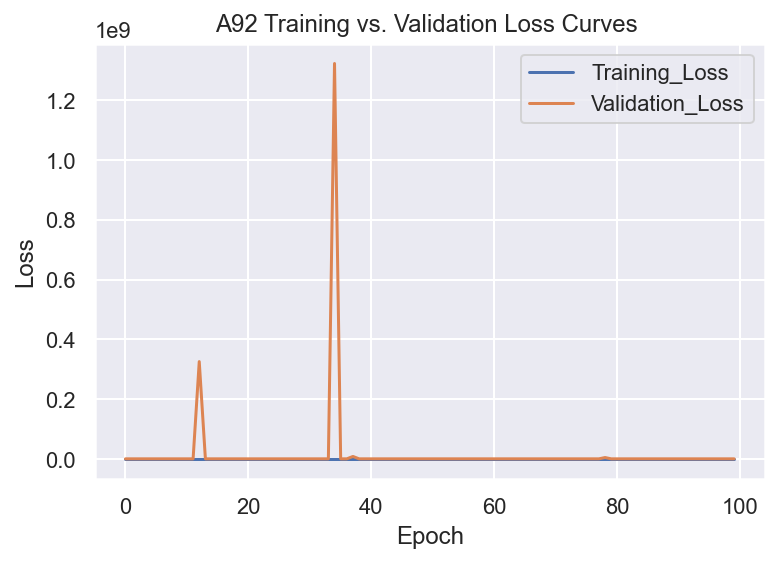

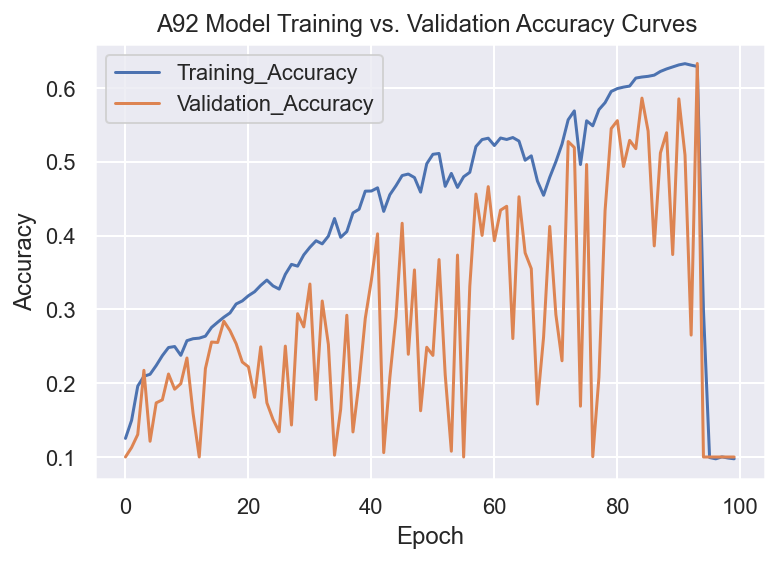

In [20]:
#A92 Model Plots
#Plot Loss curve first
plt.figure()
plt.plot(history_A92_100epoch.history['loss'],label='Training_Loss')
plt.plot(history_A92_100epoch.history['val_loss'],label='Validation_Loss')
plt.title("A92 Training vs. Validation Loss Curves ")
plt.legend()
plt.ylabel('Loss')
plt.xlabel("Epoch")

plt.savefig("fig_A92_loss_blowup.png")
plt.show()

plt.figure()
#Plot Training vs. Validation Accuracy curve for same model
plt.plot(history_A92_100epoch.history['accuracy'],label='Training_Accuracy')
plt.plot(history_A92_100epoch.history['val_accuracy'],label='Validation_Accuracy')
plt.title("A92 Model Training vs. Validation Accuracy Curves ")
plt.legend()
plt.ylabel('Accuracy')
plt.xlabel("Epoch")

plt.savefig("fig_A92_accuracy_blowup.png")

plt.show()

In [ ]:
## Test Tensorboard log files

In [23]:
tensorboard.reset_default_graph()

NameError: name 'tensorboard' is not defined

In [25]:
logdir

'logs3/scalars/20211209-022304_A92_100epoch'

In [26]:
%tensorboard --logdir logs3/scalars/20211209-022304_A92_100epoch --port 6007 --purge_orphaned_data True --reload_multifile True

## Retrain the A92 Model since it blew up at the end

In [35]:
ran_model = Attention92()
inputs = tf.keras.Input((32, 32, 3))
ran_model(inputs)
ran_model.summary()

Model: "attention92_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_2 (Sequential)    (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_759 (Conv2D)          multiple                  864       
_________________________________________________________________
batch_normalization_582 (Bat multiple                  128       
_________________________________________________________________
re_lu_582 (ReLU)             multiple                  0         
_________________________________________________________________
max_pooling2d_39 (MaxPooling multiple                  0         
_________________________________________________________________
residual_unit_180 (ResidualU multiple                  19520     
_________________________________________________________________
attention_module_18 (Attenti multiple                

In [36]:
#set up callbacks for training
checkpoint_filepath = './/tmp//checkpoint_a92_Second//'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

#set callback to reduce learning rate upon validation loss plateau
#or increase
lrReduceCallback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=15,
    verbose=1,
    mode="auto",
    min_delta=0.0001,
    cooldown=0,
    min_lr=1e-6 )

filename = 'a92_100epochModel_Second.csv'
csvCallback = tf.keras.callbacks.CSVLogger(filename, separator=",", append=False)
# code for plotting keras model
# tf.keras.utils.plot_model(
#     ran_model,
#     to_file="a92_model.png",
#     show_shapes=True,
#     show_dtype=False,
#     show_layer_names=True,
#     rankdir="TB",
#     expand_nested=True,
#     dpi=300,
# )


#  tf.distribute.MirroredStrategy(['/gpu:0', '/gpu:1'])
logdir = "logs4/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S") + "_A92_100epoch_second"
# file_writer = tf.summary.create_file_writer(logdir + "/metrics")
# file_writer.set_as_default()
   
#create tensorboard callback
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)


In [29]:
#increase n_epochs to account for slower training
N_EPOCH = 150

In [37]:
a92_model_100epoch_second = ran_model

a92_model_100epoch_second.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0037356), 
                  loss=tf.keras.losses.CategoricalCrossentropy(), 
                  metrics=['accuracy'])


history_A92_100epoch_second = a92_model_100epoch_second.fit(train_ds,
                        validation_data=val_ds,
                        epochs=N_EPOCH,callbacks=[lrReduceCallback,tensorboard_callback,model_checkpoint_callback,csvCallback])


Epoch 1/150
157/157 [==============================] - 79s 373ms/step - loss: 2.4159 - accuracy: 0.1230 - val_loss: 2.3457 - val_accuracy: 0.1000
Epoch 2/150
157/157 [==============================] - 54s 346ms/step - loss: 2.1593 - accuracy: 0.1824 - val_loss: 2.2092 - val_accuracy: 0.1741
Epoch 3/150
157/157 [==============================] - 54s 342ms/step - loss: 2.0722 - accuracy: 0.2097 - val_loss: 2.1281 - val_accuracy: 0.1765
Epoch 4/150
157/157 [==============================] - 53s 339ms/step - loss: 2.0115 - accuracy: 0.2271 - val_loss: 6.5578 - val_accuracy: 0.1219
Epoch 5/150
157/157 [==============================] - 53s 340ms/step - loss: 1.9740 - accuracy: 0.2409 - val_loss: 10.9101 - val_accuracy: 0.1022
Epoch 6/150
157/157 [==============================] - 53s 339ms/step - loss: 1.9385 - accuracy: 0.2465 - val_loss: 2.0899 - val_accuracy: 0.1874
Epoch 7/150
157/157 [==============================] - 54s 342ms/step - loss: 1.9449 - accuracy: 0.2519 - val_loss: 5.1699 

157/157 [==============================] - 53s 339ms/step - loss: 0.9249 - accuracy: 0.6817 - val_loss: 0.9945 - val_accuracy: 0.6627
Epoch 112/150
157/157 [==============================] - 53s 339ms/step - loss: 0.9279 - accuracy: 0.6836 - val_loss: 1.0345 - val_accuracy: 0.6618
Epoch 113/150
157/157 [==============================] - 53s 339ms/step - loss: 0.9256 - accuracy: 0.6827 - val_loss: 1.0276 - val_accuracy: 0.6593
Epoch 114/150
157/157 [==============================] - 53s 339ms/step - loss: 0.9253 - accuracy: 0.6837 - val_loss: 0.9917 - val_accuracy: 0.6631
Epoch 115/150
157/157 [==============================] - 53s 339ms/step - loss: 0.9182 - accuracy: 0.6863 - val_loss: 0.9846 - val_accuracy: 0.6761
Epoch 116/150
157/157 [==============================] - 53s 340ms/step - loss: 0.9218 - accuracy: 0.6837 - val_loss: 1.0222 - val_accuracy: 0.6526
Epoch 117/150
157/157 [==============================] - 53s 339ms/step - loss: 0.9237 - accuracy: 0.6838 - val_loss: 1.0073 -

## tensorboard a92

In [39]:
%tensorboard --logdir logs4/scalars --port 6008 --purge_orphaned_data True --reload_multifile True

### Attention-128

In [40]:
ran_model = Attention128()
inputs = tf.keras.Input((32, 32, 3))
ran_model(inputs)
ran_model.summary()

Model: "attention128"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_3 (Sequential)    (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_1012 (Conv2D)         multiple                  864       
_________________________________________________________________
batch_normalization_776 (Bat multiple                  128       
_________________________________________________________________
re_lu_776 (ReLU)             multiple                  0         
_________________________________________________________________
max_pooling2d_52 (MaxPooling multiple                  0         
_________________________________________________________________
residual_unit_240 (ResidualU multiple                  19520     
_________________________________________________________________
attention_module_24 (Attenti multiple                 

### Perform another learning rate search but for a128



In [41]:
def model_builder_128(hp):
    ran_model = Attention128()
    inputs = tf.keras.Input((32, 32, 3))
    ran_model(inputs)
    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.01, 0.001, or 0.0001
#     hp_learning_rate =  hp.Float('learning_rate', 1e-4, 1e-1, sampling='log'),
    ran_model.compile(optimizer=tf.keras.optimizers.Adam(hp.Float('learning_rate', 1e-4, 1e-1, sampling='log')), 
              loss=tf.keras.losses.CategoricalCrossentropy(), 
              metrics=['accuracy'])
    return ran_model

In [46]:
tuner_a128_logSample = kt.Hyperband(model_builder_128,
                     objective='val_accuracy',
                     max_epochs=30,
                     factor=3,
                     directory='NERD_dir',
                     project_name='NERD_Final_Project_A128_LR1LogSample',
                     hyperband_iterations=1)

INFO:tensorflow:Reloading Oracle from existing project NERD_dir\NERD_Final_Project_A128_LR1LogSample\oracle.json


In [ ]:
logdir = "logs6/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S") + "_A128_Hyperparams1_logSample"
file_writer = tf.summary.create_file_writer(logdir + "/metrics")
file_writer.set_as_default()

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)


# tuner.search(x_train, y_train, epochs=50, validation_data=(x_test, y_test), callbacks=[stop_early])
tuner_a128_logSample.search(train_ds, validation_data=val_ds, callbacks=[stop_early,tensorboard_callback])


Trial 35 Complete [00h 03m 27s]
val_accuracy: 0.10000000149011612

Best val_accuracy So Far: 0.1446000039577484
Total elapsed time: 01h 56m 42s

Search: Running Trial #36

Hyperparameter    |Value             |Best Value So Far 
learning_rate     |0.0044387         |0.0044387         
tuner/epochs      |4                 |2                 
tuner/initial_e...|2                 |0                 
tuner/bracket     |3                 |3                 
tuner/round       |1                 |0                 
tuner/trial_id    |0f692477cfd5809...|None              

Epoch 3/4
157/157 [==============================] - 118s 574ms/step - loss: 2.4506 - accuracy: 0.1097 - val_loss: 2.3051 - val_accuracy: 0.1000
Epoch 4/4
151/157 [===========================>..] - ETA: 2s - loss: 2.3849 - accuracy: 0.1109

In [91]:

# Get the optimal hyperparameters
best_hps_a128 =tuner_a128_logSample.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")


The hyperparameter search is complete. The optimal learning rate for the optimizer
is 0.001.



In [ ]:
best_model_a128 = tuner_a56.get_best_models()[0]


In [92]:
tuner_a128_logSample.results_summary(num_trials=10)


Results summary
Results in NERD_dir\NERD_Final_Project_A56_LR2
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
learning_rate: 0.001
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 3
tuner/round: 0
Score: 0.20080000162124634
Trial summary
Hyperparameters:
learning_rate: 0.01
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 3
tuner/round: 0
Score: 0.1931000053882599
Trial summary
Hyperparameters:
learning_rate: 0.05
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 3
tuner/round: 0
Score: 0.15729999542236328
Trial summary
Hyperparameters:
learning_rate: 0.005
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 3
tuner/round: 0
Score: 0.1509000062942505
Trial summary
Hyperparameters:
learning_rate: 0.0001
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 3
tuner/round: 0
Score: 0.10419999808073044
Trial summary
Hyperparameters:
learning_rate: 0.1
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 3
tuner/round: 

### Create callback methods and learning rate schedule
Adjust names and settings so that it will work for the A128 Model

In [ ]:
#set up callbacks for training
checkpoint_filepath = './/tmp//checkpoint_a128_tune//'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

#set callback to reduce learning rate upon validation loss plateau
#or increase
lrReduceCallback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.3,
    patience=15,
    verbose=1,
    mode="auto",
    min_delta=0.0001,
    cooldown=0,
    min_lr=1e-6 )

filename = 'a128_200epochModel.csv'
csvCallback = tf.keras.callbacks.CSVLogger(filename, separator=",", append=False)
# code for plotting keras model
# tf.keras.utils.plot_model(
#     ran_model,
#     to_file="a92_model.png",
#     show_shapes=True,
#     show_dtype=False,
#     show_layer_names=True,
#     rankdir="TB",
#     expand_nested=True,
#     dpi=300,
# )


#  tf.distribute.MirroredStrategy(['/gpu:0', '/gpu:1'])
logdir = "logs5/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S") + "_A128_200epoch"
# file_writer = tf.summary.create_file_writer(logdir + "/metrics")
# file_writer.set_as_default()
   
#create tensorboard callback
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)


In [16]:
a128_model = ran_model

a128_model.compile(optimizer=tf.keras.optimizers.Adam((learning_rate=0.0037356), 
                   loss=tf.keras.losses.CategoricalCrossentropy(), 
                   metrics=['accuracy'])


history = a128_model.fit(train_ds,
                         validation_data=val_ds,
                         epochs=N_EPOCH,callbacks=[lrReduceCallback,tensorboard_callback,model_checkpoint_callback,csvCallback], verbose=1)

Epoch 1/10
157/157 [==============================] - 97s 425ms/step - loss: 2.3997 - accuracy: 0.1120 - val_loss: 2.3032 - val_accuracy: 0.1000
Epoch 2/10
157/157 [==============================] - 62s 394ms/step - loss: 2.3201 - accuracy: 0.1385 - val_loss: 2.3081 - val_accuracy: 0.1000
Epoch 3/10
157/157 [==============================] - 62s 394ms/step - loss: 2.3025 - accuracy: 0.1425 - val_loss: 2.3207 - val_accuracy: 0.1014
Epoch 4/10
157/157 [==============================] - 62s 393ms/step - loss: 2.2850 - accuracy: 0.1495 - val_loss: 2.2386 - val_accuracy: 0.1558
Epoch 5/10
157/157 [==============================] - 62s 393ms/step - loss: 2.2778 - accuracy: 0.1456 - val_loss: 2.2371 - val_accuracy: 0.1636
Epoch 6/10
157/157 [==============================] - 62s 394ms/step - loss: 2.2649 - accuracy: 0.1521 - val_loss: 2.3654 - val_accuracy: 0.1311
Epoch 7/10
157/157 [==============================] - 62s 393ms/step - loss: 2.2690 - accuracy: 0.1529 - val_loss: 2.3923 - val_ac

### Attention-164

In [ ]:
ran_model = Attention164()
inputs = tf.keras.Input((32, 32, 3))
ran_model(inputs)
ran_model.summary()

Model: "attention164"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (None, 32, 32, 3)         0         
                                                                 
 conv2d_1037 (Conv2D)        multiple                  864       
                                                                 
 batch_normalization_796 (Ba  multiple                 128       
 tchNormalization)                                               
                                                                 
 re_lu_796 (ReLU)            multiple                  0         
                                                                 
 max_pooling2d_53 (MaxPoolin  multiple                 0         
 g2D)                                                            
                                                                 
 residual_unit_246 (Residual  multiple                

In [17]:
a164_model = ran_model

a164_model.compile(optimizer=tf.keras.optimizers.Adam(), 
                   loss=tf.keras.losses.CategoricalCrossentropy(), 
                   metrics=['accuracy'])


history = a164_model.fit(train_ds,
                         validation_data=val_ds,
                         epochs=N_EPOCH, verbose=1)

Epoch 1/10
157/157 [==============================] - 98s 425ms/step - loss: 2.1079 - accuracy: 0.1941 - val_loss: 2.1368 - val_accuracy: 0.1748
Epoch 2/10
157/157 [==============================] - 62s 395ms/step - loss: 1.9617 - accuracy: 0.2410 - val_loss: 2.9659 - val_accuracy: 0.1587
Epoch 3/10
157/157 [==============================] - 62s 395ms/step - loss: 1.9016 - accuracy: 0.2630 - val_loss: 3.4470 - val_accuracy: 0.1594


KeyboardInterrupt: ignored

In [24]:
!nvidia-smi

[autoreload of src.models.ResidualAttentionNetwork failed: Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/extensions/autoreload.py", line 247, in check
    superreload(m, reload, self.old_objects)
  File "/content/drive/MyDrive/ECBM4040/FinalProject/recreating-residual-attention-network/src/models/ResidualAttentionNetwork.py", line 83
    self.residual_unit2 = ResidualUnit(channels=self.channels[2], strides=2)
       ^
SyntaxError: invalid syntax
]


Sat Dec  4 21:33:52 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    31W / 250W |   8769MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Different Mask Structure
### Local Convolution (local attention) Mask Structure vs. Encoder-Decoder Structure (mixed attention)
Encoder-Decoder Mask Branch vs. Local Convolutions

Recreating experiment that produces table 4 from paper by implementing different mask type with local attention from local convolutions instead of mixed attention from an encoder-decoder structure.

In [18]:
#Create attention56 model but with local convolution soft mask branch
#not encoder-decoder
ran_model_local = Attention56(mask_type='local')
inputs = tf.keras.Input((32, 32, 3))
ran_model_local(inputs)
ran_model_local.summary()

Model: "attention56_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 32, 32, 3)         0         
                                                                 
 conv2d_278 (Conv2D)         multiple                  864       
                                                                 
 batch_normalization_214 (Ba  multiple                 128       
 tchNormalization)                                               
                                                                 
 re_lu_214 (ReLU)            multiple                  0         
                                                                 
 max_pooling2d_14 (MaxPoolin  multiple                 0         
 g2D)                                                            
                                                                 
 residual_unit_66 (ResidualU  multiple               

In [19]:
#train model with local conv mask structure
a56_model = ran_model_local

a56_model.compile(optimizer=tf.keras.optimizers.Adam(), 
                  loss=tf.keras.losses.CategoricalCrossentropy(), 
                  metrics=['accuracy'])


history = a56_model.fit(train_ds,
                        validation_data=val_ds,
                        epochs=N_EPOCH, verbose=1)

Epoch 1/10
157/157 [==============================] - 41s 177ms/step - loss: 2.4826 - accuracy: 0.1363 - val_loss: 2.9208 - val_accuracy: 0.1000
Epoch 2/10
157/157 [==============================] - 25s 162ms/step - loss: 2.1091 - accuracy: 0.2348 - val_loss: 2.3674 - val_accuracy: 0.1408
Epoch 3/10
157/157 [==============================] - 25s 161ms/step - loss: 1.9460 - accuracy: 0.2920 - val_loss: 2.1961 - val_accuracy: 0.2240
Epoch 4/10
157/157 [==============================] - 25s 161ms/step - loss: 1.8361 - accuracy: 0.3340 - val_loss: 1.9381 - val_accuracy: 0.2840
Epoch 5/10
157/157 [==============================] - 25s 161ms/step - loss: 1.7707 - accuracy: 0.3615 - val_loss: 1.9049 - val_accuracy: 0.3320
Epoch 6/10
157/157 [==============================] - 25s 161ms/step - loss: 1.7239 - accuracy: 0.3805 - val_loss: 1.8617 - val_accuracy: 0.3568
Epoch 7/10
157/157 [==============================] - 25s 162ms/step - loss: 1.6884 - accuracy: 0.3927 - val_loss: 1.6898 - val_ac

Rerun A56 code with encoder-decoder model for comparison


In [21]:
#set hyper-parameters to match the paper
N_EPOCH = 100
our_regularization = 0.0001 #L2
# learning_rate = 0.1

boundaries = [64000, 96000]
values = [0.1, 0.01, 0.001]


lr_schedule = keras.optimizers.schedules.PiecewiseConstantDecay(boundaries, values)
our_optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9, nesterov=True)


In [22]:
ran_model_enc_dec = Attention56(regularization=our_regularization)
inputs = tf.keras.Input((32, 32, 3))
ran_model_enc_dec(inputs)
ran_model_enc_dec.summary()

Model: "attention56_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 32, 32, 3)         0         
                                                                 
 conv2d_417 (Conv2D)         multiple                  864       
                                                                 
 batch_normalization_321 (Ba  multiple                 128       
 tchNormalization)                                               
                                                                 
 re_lu_321 (ReLU)            multiple                  0         
                                                                 
 max_pooling2d_21 (MaxPoolin  multiple                 0         
 g2D)                                                            
                                                                 
 residual_unit_99 (ResidualU  multiple               

In [23]:
a56_model_enc_dec = ran_model_enc_dec

a56_model_enc_dec.compile(optimizer=our_optimizer, 
                  loss=tf.keras.losses.CategoricalCrossentropy(), 
                  metrics=['accuracy'])


history_enc_dec = a56_model.fit(train_ds,
                        validation_data=val_ds,
                        epochs=N_EPOCH, verbose=1)

Epoch 1/100
157/157 [==============================] - 25s 162ms/step - loss: 1.5621 - accuracy: 0.4400 - val_loss: 1.6706 - val_accuracy: 0.4352
Epoch 2/100
157/157 [==============================] - 25s 162ms/step - loss: 1.5422 - accuracy: 0.4504 - val_loss: 2.1035 - val_accuracy: 0.3421
Epoch 3/100
157/157 [==============================] - 25s 161ms/step - loss: 1.5127 - accuracy: 0.4602 - val_loss: 1.5141 - val_accuracy: 0.4619
Epoch 4/100
157/157 [==============================] - 25s 161ms/step - loss: 1.4853 - accuracy: 0.4715 - val_loss: 1.9778 - val_accuracy: 0.3957
Epoch 5/100
157/157 [==============================] - 25s 162ms/step - loss: 1.4688 - accuracy: 0.4797 - val_loss: 1.4757 - val_accuracy: 0.4812
Epoch 6/100
157/157 [==============================] - 25s 161ms/step - loss: 1.4479 - accuracy: 0.4834 - val_loss: 1.7134 - val_accuracy: 0.4204
Epoch 7/100
157/157 [==============================] - 25s 161ms/step - loss: 1.4305 - accuracy: 0.4936 - val_loss: 1.6730 -

### Rerun the Local Convolution Mask Structure Training but with Same hyper-parameters as Enc-Dec and the paper



In [24]:
#Create attention56 model but with local convolution soft mask branch
#not encoder-decoder
ran_model_local = Attention56(regularization=our_regularization,mask_type='local')
inputs = tf.keras.Input((32, 32, 3))
ran_model_local(inputs)
ran_model_local.summary()

Model: "attention56_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 32, 32, 3)         0         
                                                                 
 conv2d_556 (Conv2D)         multiple                  864       
                                                                 
 batch_normalization_428 (Ba  multiple                 128       
 tchNormalization)                                               
                                                                 
 re_lu_428 (ReLU)            multiple                  0         
                                                                 
 max_pooling2d_28 (MaxPoolin  multiple                 0         
 g2D)                                                            
                                                                 
 residual_unit_132 (Residual  multiple               

In [25]:
#train model with local conv mask structure
a56_model = ran_model_local

a56_model.compile(optimizer=our_optimizer, 
                  loss=tf.keras.losses.CategoricalCrossentropy(), 
                  metrics=['accuracy'])


history_local = a56_model.fit(train_ds,
                        validation_data=val_ds,
                        epochs=N_EPOCH, verbose=1)

Epoch 1/100
157/157 [==============================] - 38s 173ms/step - loss: 2.5990 - accuracy: 0.1069 - val_loss: 4.1577 - val_accuracy: 0.0988
Epoch 2/100
157/157 [==============================] - 25s 161ms/step - loss: 2.3329 - accuracy: 0.1105 - val_loss: 2.3985 - val_accuracy: 0.1107
Epoch 3/100
157/157 [==============================] - 25s 161ms/step - loss: 2.3196 - accuracy: 0.1158 - val_loss: 2.3854 - val_accuracy: 0.1129
Epoch 4/100
157/157 [==============================] - 25s 161ms/step - loss: 2.3151 - accuracy: 0.1136 - val_loss: 2.3514 - val_accuracy: 0.1234
Epoch 5/100
157/157 [==============================] - 25s 161ms/step - loss: 2.3086 - accuracy: 0.1168 - val_loss: 2.3032 - val_accuracy: 0.1193
Epoch 6/100
157/157 [==============================] - 25s 161ms/step - loss: 2.3030 - accuracy: 0.1173 - val_loss: 2.2908 - val_accuracy: 0.1324
Epoch 7/100
157/157 [==============================] - 25s 161ms/step - loss: 2.2940 - accuracy: 0.1248 - val_loss: 2.2906 -

### Make Table Output

In [26]:
#install prettytable
!python -m pip install -U prettytable


In [34]:
top1_error_local = 1 - history_local.history.get('accuracy')[-1]
print(f"Top-1 Error for the Local Convolution Soft Mask Branch Model is: {top1_error_local*100}%")
top1_error_enc_dec = 1 - history_enc_dec.history.get('accuracy')[-1]
print(f"Top-1 Error for the Encoder-Deconder Soft Mask Branch Model is: {top1_error_enc_dec*100}%")



Top-1 Error for the Local Convolution Soft Mask Branch Model is: 78.14999967813492%
Top-1 Error for the Encoder-Deconder Soft Mask Branch Model is: 18.387502431869507%


In [43]:
from prettytable import PrettyTable
x = PrettyTable()
x.add_column("Mask Type",
["Local Convolutions","Encoder and Decoder"])
x.add_column("Attention Type", ["Local Attention","Mixed Attention"])
x.add_column("Top-1 err. (%)", [top1_error_local*100,top1_error_enc_dec*100])


In [44]:
print(x)

+---------------------+-----------------+--------------------+
|      Mask Type      |  Attention Type |   Top-1 err. (%)   |
+---------------------+-----------------+--------------------+
|  Local Convolutions | Local Attention | 78.14999967813492  |
| Encoder and Decoder | Mixed Attention | 18.387502431869507 |
+---------------------+-----------------+--------------------+


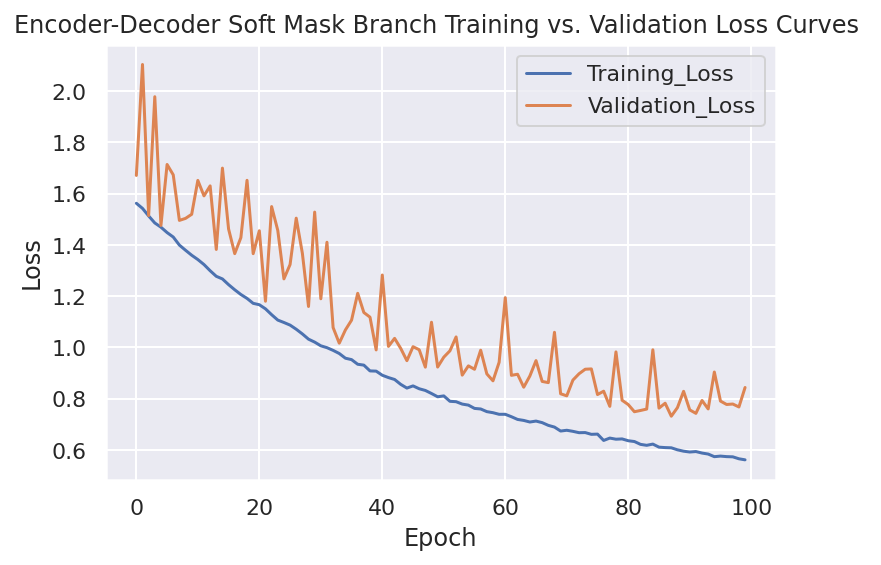

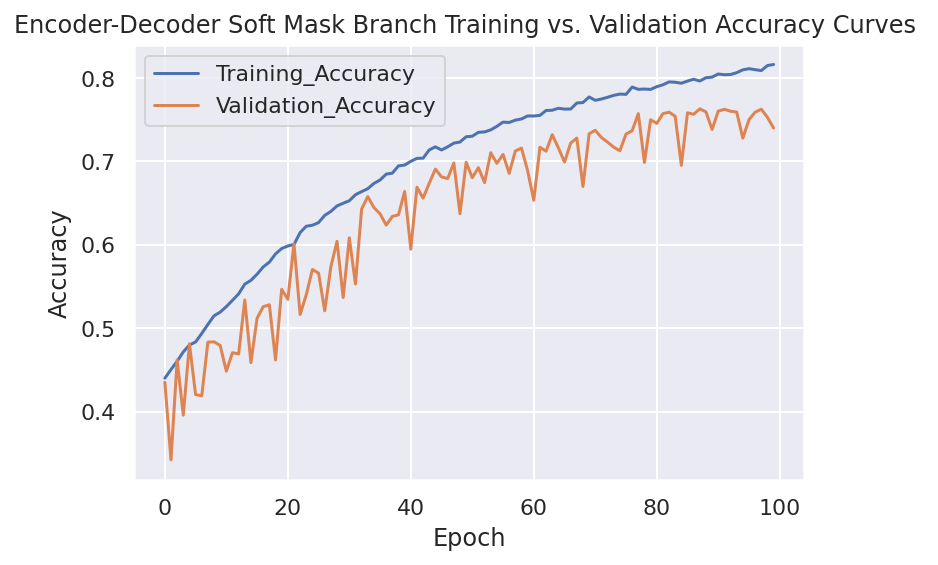

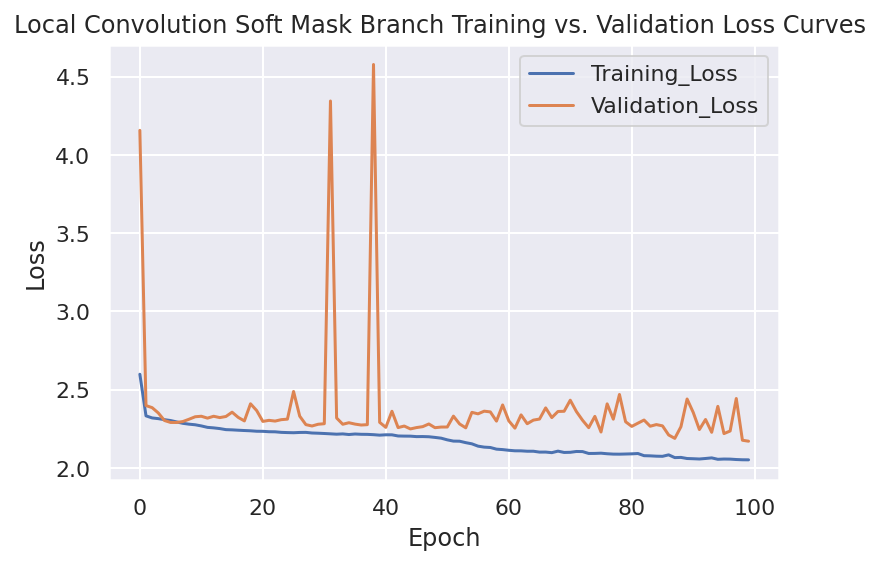

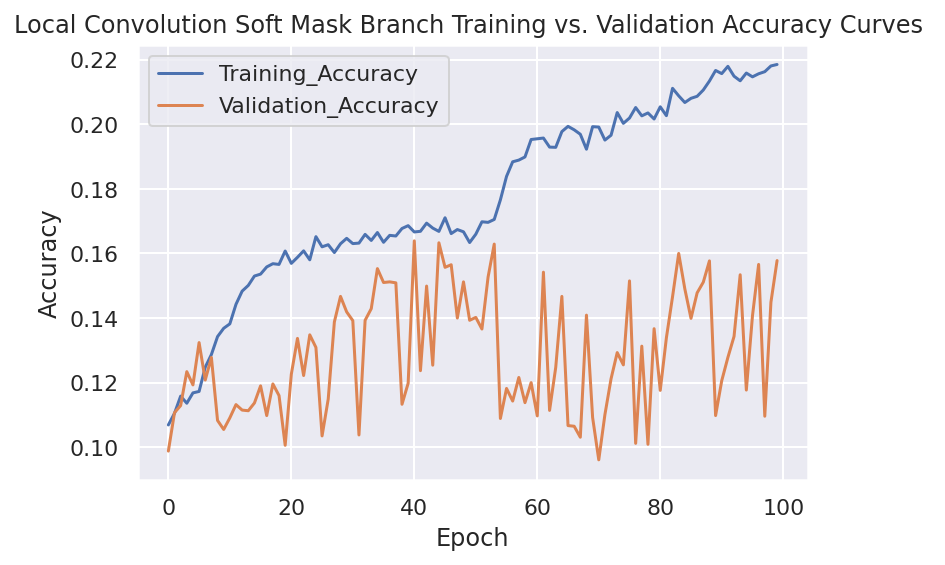

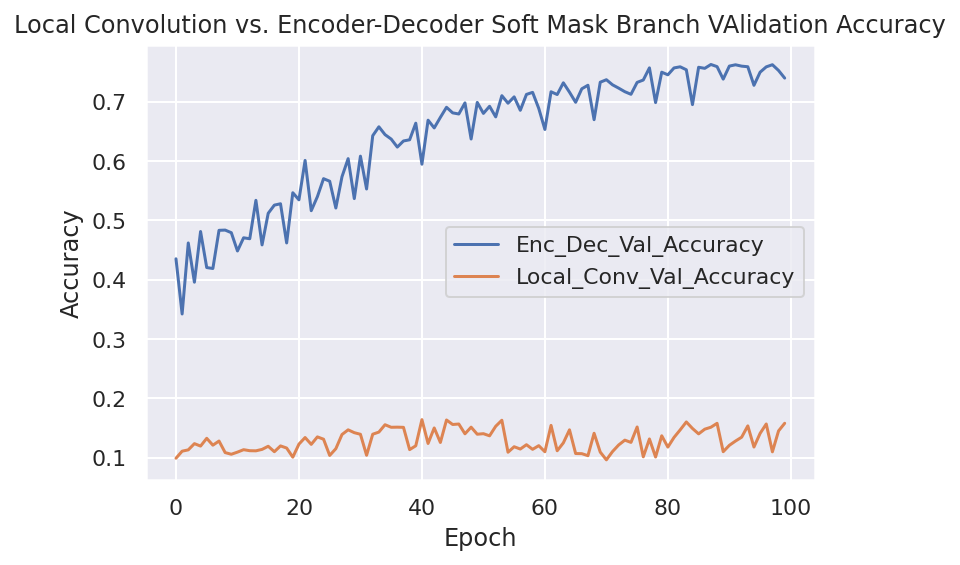

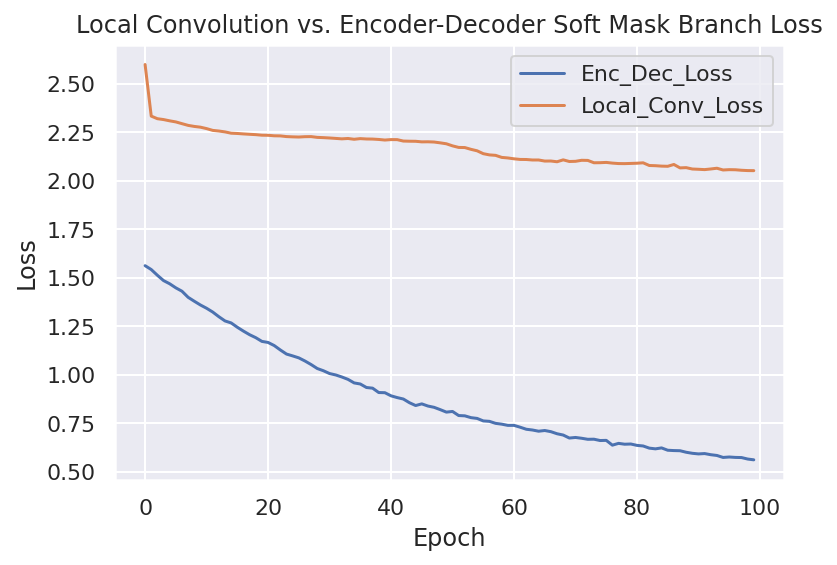

In [56]:
#plot accuracy (training vs. validation) curve and loss curve
#for each model as well as comparison plot of loss curves and 
# of validation accuracy curve

#Encoder Decoder Model Plots
#Plot Loss curve first
plt.figure()
plt.plot(history_enc_dec.history['loss'],label='Training_Loss')
plt.plot(history_enc_dec.history['val_loss'],label='Validation_Loss')
plt.title("Encoder-Decoder Soft Mask Branch Training vs. Validation Loss Curves ")
plt.legend()
plt.ylabel('Loss')
plt.xlabel("Epoch")

plt.savefig("fig1.png")
plt.show()

plt.figure()
#Plot Training vs. Validation Accuracy curve for same model
plt.plot(history_enc_dec.history['accuracy'],label='Training_Accuracy')
plt.plot(history_enc_dec.history['val_accuracy'],label='Validation_Accuracy')
plt.title("Encoder-Decoder Soft Mask Branch Training vs. Validation Accuracy Curves ")
plt.legend()
plt.ylabel('Accuracy')
plt.xlabel("Epoch")

plt.savefig("fig2.png")

plt.show()



#Local Convolution Mask Branch Model Plots
#loss curve for LocalConv model
plt.figure()
plt.plot(history_local.history['loss'],label='Training_Loss')
plt.plot(history_local.history['val_loss'],label='Validation_Loss')
plt.title("Local Convolution Soft Mask Branch Training vs. Validation Loss Curves ")
plt.legend()
plt.ylabel('Loss')
plt.xlabel("Epoch")

plt.savefig("fig3.png")

plt.show()

#accuracy curve
plt.figure()
#Plot Training vs. Validation Accuracy curve for LocalConv model
plt.plot(history_local.history['accuracy'],label='Training_Accuracy')
plt.plot(history_local.history['val_accuracy'],label='Validation_Accuracy')
plt.title("Local Convolution Soft Mask Branch Training vs. Validation Accuracy Curves ")
plt.legend()
plt.ylabel('Accuracy')
plt.xlabel("Epoch")

plt.savefig("fig4.png")

plt.show()


#####
#Comparison Plots
#####


#Enc-Dec Model Mask Branch Model Validation Loss vs. Local Convolution
# Mask Branch Model Validation Loss

#loss curve for LocalConv model
plt.figure()
plt.plot(history_enc_dec.history['val_accuracy'],label='Enc_Dec_Val_Accuracy')
plt.plot(history_local.history['val_accuracy'],label='Local_Conv_Val_Accuracy')
plt.title("Local Convolution vs. Encoder-Decoder Soft Mask Branch VAlidation Accuracy")
plt.legend()
plt.ylabel('Accuracy')
plt.xlabel("Epoch")

plt.savefig("fig5.png")

plt.show()



#Enc-Dec Model Mask Branch Model Validation Accuracy vs. Local Convolution
# Mask Branch Model Validation Accuracy

plt.figure()
plt.plot(history_enc_dec.history['loss'],label='Enc_Dec_Loss')
plt.plot(history_local.history['loss'],label='Local_Conv_Loss')
plt.title("Local Convolution vs. Encoder-Decoder Soft Mask Branch Loss")
plt.legend()
plt.ylabel('Loss')
plt.xlabel("Epoch")

plt.savefig("fig6.png")

plt.show()





### Save Models for Different Mask Branch Type Replication from Paper

In [49]:
#Save Models for posterity
#encode-decoder mask branch 
a56_model_enc_dec.save_weights('cifar10_enc_dec_Mask_Nesterov_RAN_100epoch_val.h5')
#local convolution mask branch
a56_model.save_weights('cifar10_local_conv_Mask_Nesterov_RAN_100epoch_val.h5')

In [53]:
# #Save Models for posterity
# #encode-decoder mask branch 
# a56_model_enc_dec.save('cifar10_enc_dec_Mask_Nesterov_RAN_100epoch_val',save_format='tf')
# #local convolution mask branch
# a56_model.save('cifar10_local_conv_Mask_Nesterov_RAN_100epoch_val', save_format='tf')

## Rerun the training for the local convolution mask branch model because initialization was much worse than for the encoder decoder branch model


In [ ]:
#set hyper-parameters to match the paper
N_EPOCH = 100
our_regularization = 0.0001 #L2
# learning_rate = 0.1

boundaries = [64000, 96000]
values = [0.1, 0.01, 0.001]


lr_schedule = keras.optimizers.schedules.PiecewiseConstantDecay(boundaries, values)
our_optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9, nesterov=True)


In [ ]:
### Rerun Local conv training due to apparent poor initialization 
#Create attention56 model but with local convolution soft mask branch
#not encoder-decoder
ran_model_local2 = Attention56(regularization=our_regularization,mask_type='local')
inputs = tf.keras.Input((32, 32, 3))
ran_model_local2(inputs)
ran_model_local2.summary()

In [ ]:
#train model with local conv mask structure
a56_model_local2 = ran_model_local2

a56_model_local2.compile(optimizer=our_optimizer, 
                  loss=tf.keras.losses.CategoricalCrossentropy(), 
                  metrics=['accuracy'])


a56_model_local2 = a56_model.fit(train_ds,
                        validation_data=val_ds,
                        epochs=N_EPOCH, verbose=1)

In [ ]:
#plot accuracy (training vs. validation) curve and loss curve
#for each model as well as comparison plot of loss curves and 
# of validation accuracy curve

#Encoder Decoder Model Plots
#Plot Loss curve first
plt.figure()
plt.plot(history_enc_dec.history['loss'],label='Training_Loss')
plt.plot(history_enc_dec.history['val_loss'],label='Validation_Loss')
plt.Title("Encoder-Decoder Soft Mask Branch Training vs. Validation Loss Curves ")
plt.savefig("fig01.png")
plt.show()

plt.figure()
#Plot Training vs. Validation Accuracy curve for same model
plt.plot(history_enc_dec.history['accuracy'],label='Training_Accuracy')
plt.plot(history_enc_dec.history['val_accuracy'],label='Validation_Accuracy')
plt.Title("Encoder-Decoder Soft Mask Branch Training vs. Validation Accuracy Curves ")
plt.savefig("fig02.png")

plt.show()



#Local Convolution Mask Branch Model Plots
#loss curve for LocalConv model
plt.figure()
plt.plot(history_local2.history['loss'],label='Training_Loss')
plt.plot(history_local2.history['val_loss'],label='Validation_Loss')
plt.Title("Local Convolution Soft Mask Branch Training vs. Validation Loss Curves ")
plt.savefig("fig03.png")

plt.show()

#accuracy curve
plt.figure()
#Plot Training vs. Validation Accuracy curve for LocalConv model
plt.plot(history_local2.history['accuracy'],label='Training_Accuracy')
plt.plot(history_local2.history['val_accuracy'],label='Validation_Accuracy')
plt.Title("Local Convolution Soft Mask Branch Training vs. Validation Accuracy Curves ")
plt.savefig("fig04.png")

plt.show()


#####
#Comparison Plots
#####


#Enc-Dec Model Mask Branch Model Validation Loss vs. Local Convolution
# Mask Branch Model Validation Loss

#loss curve for LocalConv model
plt.figure()
plt.plot(history_enc_dec.history['val_accuracy'],label='Enc_Dec_Val_Accuracy')
plt.plot(history_local2.history['val_accuracy'],label='Local_Conv_Val_Accuracy')
plt.Title("Local Convolution vs. Encoder-Decoder Soft Mask Branch VAlidation Accuracy")
plt.savefig("fig05.png")

plt.show()



#Enc-Dec Model Mask Branch Model Validation Accuracy vs. Local Convolution
# Mask Branch Model Validation Accuracy

plt.figure()
plt.plot(history_enc_dec.history['loss'],label='Enc_Dec_Loss')
plt.plot(history_local2.history['loss'],label='Local_Conv_Loss')
plt.Title("Local Convolution vs. Encoder-Decoder Soft Mask Branch Loss")
plt.savefig("fig06.png")

plt.show()





In [ ]:
#save new local conv model
#Save Models for posterity
#encode-decoder mask branch 
a56_model_local2.save('cifar10_local2_Mask_Nesterov_RAN_100epoch_val.h5')
